# Matrix Factorization (SVD)
Train the SVD model, inspect latent factors, evaluate prediction accuracy, and generate top-N recommendations.

In [1]:
import sys
from pathlib import Path

ROOT = Path().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.loader import load_dataset
from src.data.preprocessing import (
    enrich_movies, cap_dataset, build_interaction_matrix, temporal_train_test_split
)
from src.models.svd import train_svd, predict_pairs, recommend_from_factors, factor_top_movies
from src.models.evaluation import prediction_error_metrics, precision_recall_at_k
import numpy as np
import pandas as pd

ds = load_dataset(ROOT / 'data' / 'raw', max_rows=300_000)
ratings = cap_dataset(ds.ratings, max_users=6000, max_movies=3000)
movies  = enrich_movies(ds.movies)
train_df, test_df = temporal_train_test_split(ratings, test_ratio=0.2)
bundle  = build_interaction_matrix(train_df)
print('Matrix:', bundle.matrix.shape)

Matrix: (1920, 3000)


In [2]:
# Train SVD with 50 latent factors
artifacts = train_svd(bundle.matrix, n_factors=50, n_iter=10)
print('User factor matrix:', artifacts.user_factors.shape)
print('Item factor matrix:', artifacts.item_factors.shape)
print('Singular values (first 10):', artifacts.singular_values[:10].round(2))

User factor matrix: (1920, 50)
Item factor matrix: (3000, 50)
Singular values (first 10): [745.15 362.49 255.23 230.94 214.31 193.31 188.37 156.82 153.13 139.56]


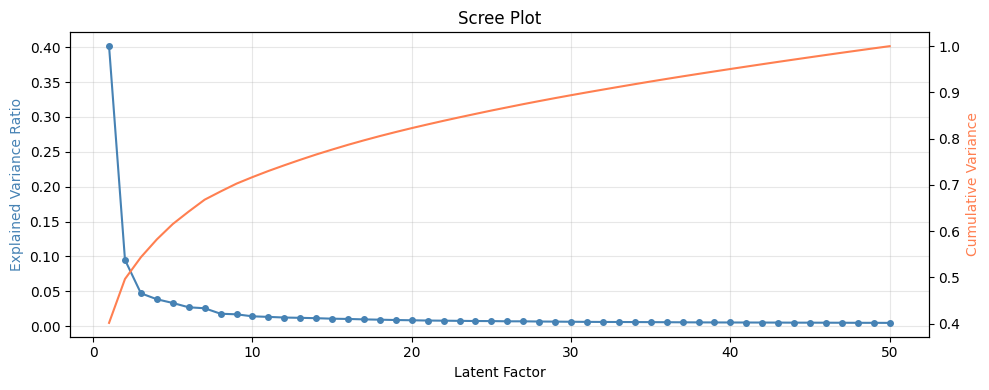

In [3]:
import matplotlib.pyplot as plt

# Scree plot
sv = artifacts.singular_values
explained = (sv ** 2) / np.sum(sv ** 2)
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()
ax1.plot(range(1, len(sv)+1), explained, marker='o', ms=4, color='steelblue', label='Explained Variance')
ax2.plot(range(1, len(sv)+1), np.cumsum(explained), color='coral', label='Cumulative')
ax1.set_xlabel('Latent Factor')
ax1.set_ylabel('Explained Variance Ratio', color='steelblue')
ax2.set_ylabel('Cumulative Variance', color='coral')
ax1.set_title('Scree Plot')
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Prediction accuracy on held-out pairs
valid_test = test_df[
    test_df['userId'].isin(bundle.user_to_index) &
    test_df['movieId'].isin(bundle.movie_to_index)
].sample(min(50_000, len(test_df)), random_state=42)

uidx = valid_test['userId'].map(bundle.user_to_index).to_numpy(np.int32)
midx = valid_test['movieId'].map(bundle.movie_to_index).to_numpy(np.int32)
y_pred = predict_pairs(artifacts, uidx, midx)
metrics = prediction_error_metrics(valid_test['rating'].to_numpy(), y_pred)
print(f"RMSE: {metrics['rmse']:.4f}  |  MAE: {metrics['mae']:.4f}")

RMSE: 3.1170  |  MAE: 2.9051


In [5]:
# Top-N recommendations for a sample user
sample_user = int(train_df['userId'].value_counts().index[0])
recs = recommend_from_factors(
    user_id=sample_user,
    matrix=bundle.matrix,
    user_to_index=bundle.user_to_index,
    movie_ids=bundle.movie_ids,
    artifacts=artifacts,
    top_n=10,
)
title_map = movies.set_index('movieId')['title'].to_dict()
print(f'Top-10 for user {sample_user}:')
for mid, score in recs:
    print(f'  {title_map.get(mid, str(mid)):<55}  {score:.3f}')

Top-10 for user 28:
  Shanghai Noon (2000)                                     3.209
  From Dusk Till Dawn (1996)                               3.063
  Troy (2004)                                              3.024
  Rush Hour 2 (2001)                                       2.963
  Simple Plan, A (1998)                                    2.890
  Day After Tomorrow, The (2004)                           2.703
  Kingpin (1996)                                           2.651
  12 Angry Men (1957)                                      2.467
  Coming to America (1988)                                 2.384
  Miller's Crossing (1990)                                 2.339


In [6]:
# Top movies per latent factor
top_factors = factor_top_movies(artifacts=artifacts, movie_ids=bundle.movie_ids, movies=movies, top_n=5)
for factor_idx, entries in list(top_factors.items())[:4]:
    print(f'Factor {factor_idx}:', [e['title'] for e in entries])

Factor 0: ['Fatal Instinct (1993)', 'Diabolique (1996)', 'Eye for an Eye (1996)', 'Jade (1995)', "Nightmare on Elm Street 2: Freddy's Revenge, A (1985)"]
Factor 1: ['Inception (2010)', 'Dark Knight, The (2008)', 'Interstellar (2014)', 'Dark Knight Rises, The (2012)', 'Django Unchained (2012)']
Factor 2: ['Forrest Gump (1994)', 'Fugitive, The (1993)', 'Jurassic Park (1993)', 'Shawshank Redemption, The (1994)', 'Apollo 13 (1995)']
Factor 3: ['Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)', 'Godfather, The (1972)', "Schindler's List (1993)"]
